In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# 1 input channel (greyscale), 6 features (filters), 3 (3x3) kernel size, 1 step size (stride)
conv1 = nn.Conv2d(1,6,3,1) # --> 6 filters --> Pooling --> conv2

# 6 inputs filters, 16 filters (cause why not), 3x3 kernel size, stride=1
conv2 = nn.Conv2d(6,16,3,1)

In [9]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape # --> 4D batch

torch.Size([1, 28, 28])

In [11]:
x = X_train.view((1,1,28,28))

In [12]:
x.shape

torch.Size([1, 1, 28, 28])

In [13]:
x = F.relu(conv1(x))

In [14]:
x.shape

torch.Size([1, 6, 26, 26])

In [15]:
x = F.max_pool2d(x,2,2)

In [16]:
x.shape

torch.Size([1, 6, 13, 13])

In [17]:
x = F.relu(conv2(x))

In [18]:
x.shape

torch.Size([1, 16, 11, 11])

In [19]:
x = F.max_pool2d(x,2,2)

In [20]:
x.shape

torch.Size([1, 16, 5, 5])

In [21]:
(((28-2)//2)-2)//2

5

In [22]:
x.flatten().reshape(1,-1).shape

torch.Size([1, 400])

In [23]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

In [24]:
def calculate_output(w,k,p,s):
    return (((w-k+2*p))//s+1)

In [25]:
number = calculate_output(28,3,0,1)
number = calculate_output(number,2,0,2)
number = calculate_output(number,3,0,1)
number = calculate_output(number,2,0,2)
print(number)

5


In [26]:
#Model class

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1, 16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [27]:
torch.manual_seed(42)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [36]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.00015489  accuracy:  99.200%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.00234043  accuracy:  98.992%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.00053026  accuracy:  98.894%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01397146  accuracy:  98.838%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.05927067  accuracy:  98.903%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00006961  accuracy:  98.869%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00022302  accuracy:  98.864%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00100109  accuracy:  98.875%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00096641  accuracy:  98.869%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00054651  accuracy:  98.848%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00003360  accuracy:  99.050%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.24818130  accuracy:  99.142%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00009969  accuracy:  99.067%
epoch:  1  b

### Model evaluation

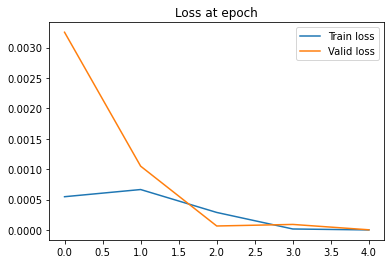

In [38]:
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Valid loss")
plt.title('Loss at epoch')
plt.legend()

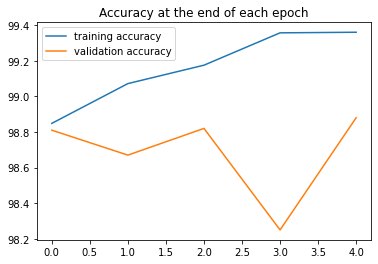

In [39]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [40]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [41]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted ==y_test).sum()

In [44]:
correct.item()/len(test_data)*100

98.88

In [45]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 971    0    0    0    0    3    1    0    2    0]
 [   0 1128    0    1    0    0    3    1    0    0]
 [   0    0 1021    2    3    0    0    5    1    0]
 [   0    0    2  985    0    2    0    1    1    0]
 [   0    0    0    0  972    0    2    0    0    4]
 [   0    1    0   14    0  886    3    1    1    4]
 [   5    1    1    0    1    1  948    0    0    0]
 [   2    3    5    3    1    0    0 1015    0    3]
 [   1    1    3    4    0    0    1    1  965    1]
 [   1    1    0    1    5    0    0    4    4  997]]


### New single image run through the model

In [48]:
test_data[2019][0].shape

torch.Size([1, 28, 28])

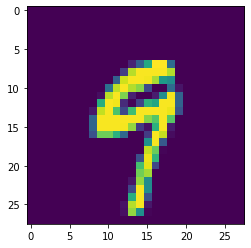

In [49]:
plt.imshow(test_data[2019][0].reshape(28,28))

1


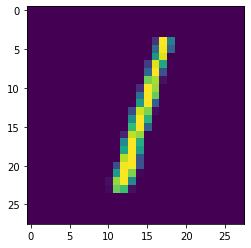

In [58]:
number = 2

plt.imshow(test_data[number][0].reshape(28,28))
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[number][0].view(1,1,28,28))
result = new_prediction.argmax().item()
print(result)